# Fractionally Differentiated Features

In [1]:
#%load_ext watermark
#%watermark

%load_ext autoreload
%autoreload 2

# import standard libs
from IPython.display import display
#from IPython.core.debugger import set_trace as bp
from pathlib import PurePath, Path
import sys
import time
from collections import OrderedDict as od
import re
import os
import json

# get project dir
pp = PurePath(Path.cwd()).parts[:-1]
pdir = PurePath(*pp)
data_script_dir = pdir / 'src' / 'data'
bars_script_dir = pdir / 'src' / 'features'
sys.path.append(data_script_dir.as_posix())
sys.path.append(bars_script_dir.as_posix())
viz_dir = pdir / 'reports' / 'figures'
data_dir = pdir / 'data'


# import python scientific stack
import pandas as pd
import pandas_datareader.data as web
pd.set_option('display.max_rows', 100)
from dask import dataframe as dd
from dask.diagnostics import ProgressBar
from multiprocessing import cpu_count
pbar = ProgressBar()
pbar.register()
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from numba import jit
import math
import ffn

# import visual tools
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns

plt.style.use('seaborn-talk')
plt.style.use('bmh')
#plt.rcParams['font.family'] = 'DejaVu Sans Mono'
plt.rcParams['font.size'] = 9.5
plt.rcParams['font.weight'] = 'medium'
plt.rcParams['figure.figsize'] = 10,7
blue, green, red, purple, gold, teal = sns.color_palette('colorblind', 6)

# import util libs
from tqdm import tqdm, tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
import missingno as msno
from utils import cprint
from bars import *

from statsmodels.tsa.stattools import adfuller

RANDOM_STATE = 777

print()
#%watermark -p pandas,pandas_datareader,dask,numpy,sklearn,statsmodels,scipy,ffn,matplotlib,seaborn

## Code Snippets

Below I reproduce all the relevant code snippets found in the book that are necessary to work through the excercises found at the end of chapter 3.

In [2]:
def select_sample_data(ref, sub, price_col, date):
    '''
    select a sample of data based on date, assumes datetimeindex
    
    # args
        ref: pd.DataFrame containing all ticks
        sub: subordinated pd.DataFrame of prices
        price_col: str(), price column
        date: str(), date to select
    # returns
        xdf: ref pd.Series
        xtdf: subordinated pd.Series
    '''
    xdf = ref[price_col].loc[date]
    xtdf = sub[price_col].loc[date]
    return xdf, xtdf

def plot_sample_data(ref, sub, bar_type, *args, **kwds):
    f,axes=plt.subplots(3,sharex=True, sharey=True, figsize=(10,7))
    ref.plot(*args, **kwds, ax=axes[0], label='price')
    sub.plot(*args, **kwds, ax=axes[0], marker='X', ls='', label=bar_type)
    axes[0].legend();
    
    ref.plot(*args, **kwds, ax=axes[1], label='price', marker='o')
    sub.plot(*args, **kwds, ax=axes[2], ls='', marker='X',
             color='r', label=bar_type)

    for ax in axes[1:]: ax.legend()
    plt.tight_layout()
    
    return

### Symmetric CUSUM Filter [2.5.2.1]

In [3]:
def getTEvents(gRaw, h):
    tEvents, sPos, sNeg = [], 0, 0
    diff = np.log(gRaw).diff().dropna()#.abs()
    for i in tqdm(diff.index[1:]):
        try:
            pos, neg = float(sPos+diff.loc[i]), float(sNeg+diff.loc[i])
        except Exception as e:
            print(e)
            print(sPos+diff.loc[i], type(sPos+diff.loc[i]))
            print(sNeg+diff.loc[i], type(sNeg+diff.loc[i]))
            break
        sPos, sNeg=max(0., pos), min(0., neg)
        if sNeg<-h:
            sNeg=0;tEvents.append(i)
        elif sPos>h:
            sPos=0;tEvents.append(i)
    return pd.DatetimeIndex(tEvents)

### Daily Volatility Estimator [3.1]

In [4]:
def getDailyVol(close,span0=100):
    # daily vol reindexed to close
    df0=close.index.searchsorted(close.index-pd.Timedelta(days=1))
    df0=df0[df0>0]   
    df0=(pd.Series(close.index[df0-1], 
                   index=close.index[close.shape[0]-df0.shape[0]:]))   
    try:
        df0=close.loc[df0.index]/close.loc[df0.values].values-1 # daily rets
    except Exception as e:
        print(f'error: {e}\nplease confirm no duplicate indices')
    df0=df0.ewm(span=span0).std().rename('dailyVol')
    return df0

### Triple-Barrier Labeling Method [3.2]

In [5]:
def applyPtSlOnT1(close,events,ptSl,molecule):
    # apply stop loss/profit taking, if it takes place before t1 (end of event)
    events_=events.loc[molecule]
    out=events_[['t1']].copy(deep=True)
    if ptSl[0]>0: pt=ptSl[0]*events_['trgt']
    else: pt=pd.Series(index=events.index) # NaNs
    if ptSl[1]>0: sl=-ptSl[1]*events_['trgt']
    else: sl=pd.Series(index=events.index) # NaNs
    for loc,t1 in events_['t1'].fillna(close.index[-1]).iteritems():
        df0=close[loc:t1] # path prices
        df0=(df0/close[loc]-1)*events_.at[loc,'side'] # path returns
        out.loc[loc,'sl']=df0[df0<sl[loc]].index.min() # earliest stop loss
        out.loc[loc,'pt']=df0[df0>pt[loc]].index.min() # earliest profit taking
    return out

### Gettting Time of First Touch (getEvents) [3.3], [3.6]

In [6]:
#Calcola, in base ai parametri passati, il target e la data in cui viene raggiunto
def getEvents(close, tEvents, ptSl, trgt, minRet, numThreads, t1=False, side=None):
    #1) get target
    trgt=trgt.loc[tEvents]
    trgt=trgt[trgt>minRet] # minRet
    #2) get t1 (max holding period)
    if t1 is False:
        t1=pd.Series(pd.NaT, index=tEvents)
    #3) form events object, apply stop loss on t1
    if side is None:
        side_,ptSl_= pd.Series(1.,index=trgt.index), [ptSl[0], ptSl[0]]
    else: 
        side_,ptSl_= side.loc[trgt.index], ptSl[:2]

    events=(pd.concat({'t1':t1,'trgt':trgt,'side':side_}, axis=1)
            .dropna(subset=['trgt']))
    
    df0=mpPandasObj(func=applyPtSlOnT1,pdObj=('molecule',events.index),
                    numThreads=numThreads,close=close,events=events,
                    ptSl=ptSl_)
    
    events['t1']=df0.dropna(how='all').min(axis=1) # pd.min ignores nan
    
    if side is None:
        events=events.drop('side',axis=1)
    
    return events

### Adding Vertical Barrier [3.4]

In [7]:
def addVerticalBarrier(tEvents, close, numDays=1):
    t1=close.index.searchsorted(tEvents+pd.Timedelta(days=numDays))
    t1=t1[t1<close.shape[0]]
    t1=(pd.Series(close.index[t1],index=tEvents[:t1.shape[0]]))
    return t1

### Labeling for side and size [3.5]

In [8]:
def getBinsOld(events,close):
    #1) prices aligned with events
    events_=events.dropna(subset=['t1'])
    px=events_.index.union(events_['t1'].values).drop_duplicates()
    px=close.reindex(px,method='bfill')
    #2) create out object
    out=pd.DataFrame(index=events_.index)
    out['ret']=px.loc[events_['t1'].values].values/px.loc[events_.index]-1
    out['bin']=np.sign(out['ret'])
    # where out index and t1 (vertical barrier) intersect label 0
    try:
        locs = out.query('index in @t1').index
        out.loc[locs, 'bin'] = 0
    except:
        pass
    return out

### Expanding getBins to Incorporate Meta-Labeling [3.7]

In [9]:
# In base alla data di inizio e di raggiungimento del target determina il ritorno in termini
# percentuali e assegna l'etichetta
def getBins(events, close):
    '''
    Compute event's outcome (including side information, if provided).
    events is a DataFrame where:
    -events.index is event's starttime
    -events['t1'] is event's endtime
    -events['trgt'] is event's target
    -events['side'] (optional) implies the algo's position side
    Case 1: ('side' not in events): bin in (-1,1) <-label by price action
    Case 2: ('side' in events): bin in (0,1) <-label by pnl (meta-labeling)
    '''
    #1) prices aligned with events
    events_=events.dropna(subset=['t1'])
    px=events_.index.union(events_['t1'].values).drop_duplicates()
    px=close.reindex(px,method='bfill')
    #2) create out object
    out=pd.DataFrame(index=events_.index)
    out['ret']=px.loc[events_['t1'].values].values/px.loc[events_.index]-1
    if 'side' in events_:out['ret']*=events_['side'] # meta-labeling
    out['bin']=np.sign(out['ret'])
    if 'side' in events_:out.loc[out['ret']<=0,'bin']=0 # meta-labeling
    return out

### Dropping Unnecessary Labels [3.8]

In [10]:
def dropLabels(events, minPct=.05):
    # apply weights, drop labels with insufficient examples
    while True:
        df0=events['bin'].value_counts(normalize=True)
        if df0.min()>minPct or df0.shape[0]<3:break
        print('dropped label: ', df0.argmin(),df0.min())
        events=events[events['bin']!=df0.argmin()]
    return events

### Linear Partitions [20.4.1]

In [11]:
def linParts(numAtoms,numThreads):
    # partition of atoms with a single loop
    parts=np.linspace(0,numAtoms,min(numThreads,numAtoms)+1)
    parts=np.ceil(parts).astype(int)
    return parts

In [12]:
def nestedParts(numAtoms,numThreads,upperTriang=False):
    # partition of atoms with an inner loop
    parts,numThreads_=[0],min(numThreads,numAtoms)
    for num in range(numThreads_):
        part=1+4*(parts[-1]**2+parts[-1]+numAtoms*(numAtoms+1.)/numThreads_)
        part=(-1+part**.5)/2.
        parts.append(part)
    parts=np.round(parts).astype(int)
    if upperTriang: # the first rows are heaviest
        parts=np.cumsum(np.diff(parts)[::-1])
        parts=np.append(np.array([0]),parts)
    return parts

### multiprocessing snippet [20.7]

In [13]:
def mpPandasObj(func,pdObj,numThreads=24,mpBatches=1,linMols=True,**kargs):
    '''
    Parallelize jobs, return a dataframe or series
    + func: function to be parallelized. Returns a DataFrame
    + pdObj[0]: Name of argument used to pass the molecule
    + pdObj[1]: List of atoms that will be grouped into molecules
    + kwds: any other argument needed by func
    
    Example: df1=mpPandasObj(func,('molecule',df0.index),24,**kwds)
    '''
    import pandas as pd
    #if linMols:parts=linParts(len(argList[1]),numThreads*mpBatches)
    #else:parts=nestedParts(len(argList[1]),numThreads*mpBatches)
    if linMols:parts=linParts(len(pdObj[1]),numThreads*mpBatches)
    else:parts=nestedParts(len(pdObj[1]),numThreads*mpBatches)
    
    jobs=[]
    for i in range(1,len(parts)):
        job={pdObj[0]:pdObj[1][parts[i-1]:parts[i]],'func':func}
        job.update(kargs)
        jobs.append(job)
    if numThreads==1:out=processJobs_(jobs)
    else: out=processJobs(jobs,numThreads=numThreads)
    if isinstance(out[0],pd.DataFrame):df0=pd.DataFrame()
    elif isinstance(out[0],pd.Series):df0=pd.Series()
    else:return out
    for i in out:df0=df0.append(i)
    df0=df0.sort_index()
    return df0

### single-thread execution for debugging [20.8]

In [14]:
def processJobs_(jobs):
    # Run jobs sequentially, for debugging
    out=[]
    for job in jobs:
        out_=expandCall(job)
        out.append(out_)
    return out

### Example of async call to multiprocessing lib [20.9]

In [15]:
import multiprocessing as mp
import datetime as dt

#________________________________
def reportProgress(jobNum,numJobs,time0,task):
    # Report progress as asynch jobs are completed
    msg=[float(jobNum)/numJobs, (time.time()-time0)/60.]
    msg.append(msg[1]*(1/msg[0]-1))
    timeStamp=str(dt.datetime.fromtimestamp(time.time()))
    msg=timeStamp+' '+str(round(msg[0]*100,2))+'% '+task+' done after '+ \
        str(round(msg[1],2))+' minutes. Remaining '+str(round(msg[2],2))+' minutes.'
    if jobNum<numJobs:sys.stderr.write(msg+'\r')
    else:sys.stderr.write(msg+'\n')
    return
#________________________________
def processJobs(jobs,task=None,numThreads=24):
    # Run in parallel.
    # jobs must contain a 'func' callback, for expandCall
    if task is None:task=jobs[0]['func'].__name__
    pool=mp.Pool(processes=numThreads)
    outputs,out,time0=pool.imap_unordered(expandCall,jobs),[],time.time()
    # Process asyn output, report progress
    for i,out_ in enumerate(outputs,1):
        out.append(out_)
        reportProgress(i,len(jobs),time0,task)
    pool.close();pool.join() # this is needed to prevent memory leaks
    return out

### Unwrapping the Callback [20.10]

In [16]:
def expandCall(kargs):
    # Expand the arguments of a callback function, kargs['func']
    func=kargs['func']
    del kargs['func']
    out=func(**kargs)
    return out

### Pickle Unpickling Objects [20.11]

In [17]:
def _pickle_method(method):
    func_name=method.im_func.__name__
    obj=method.im_self
    cls=method.im_class
    return _unpickle_method, (func_name,obj,cls)
#________________________________
def _unpickle_method(func_name,obj,cls):
    for cls in cls.mro():
        try:func=cls.__dict__[func_name]
        except KeyError:pass
        else:break
    return func.__get__(obj,cls)
#________________________________
import copyreg,types, multiprocessing as mp
copyreg.pickle(types.MethodType,_pickle_method,_unpickle_method)

### Estimating uniqueness of a label [4.1]

In [18]:
def mpNumCoEvents(closeIdx, t1, molecule):
    '''
    Compute the number of concurrent events per bar
    +molecule[0] is the date of the first event on which the weight will be computed
    +molecule[-1] is the date of the last event on which the weight will be computed
    Any event that starts before t1[molecule].max() impacts the count
    '''
    #1) Find any events that span the period molecule[0] molecule[-1]
    t1 = t1.fillna(closeIdx[-1])
    t1 = t1[t1 >= molecule[0]]
    t1 = t1.loc[:t1[molecule].max()]
    #2) Count events spanning the bar
    iloc = closeIdx.searchsorted(np.array([t1.index[0], t1.max()]))
    count = pd.Series(0, index=closeIdx[iloc[0]:iloc[-1]+1])
    for tIn, tOut in t1.iteritems():
        count.loc[tIn:tOut] += 1
    return count.loc[molecule[0]:t1[molecule].max()]

In [19]:
def getWeights(d, size):
    # Threshold  > 0
    w=[1.]
    for k in range(1, size):
        w_ = -w[-1]/k*(d-k+1)
        w.append(w_)
    w = np.array(w[::-1]).reshape(-1, 1)
    return w

# ------------------------
def plotWeights(dRange, nPlots, size):
    w = pd.DataFrame()
    for d in np.linspace(dRange[0], dRange[1], nPlots):
        w_ = getWeights(d, size=size)
        w_ = pd.DataFrame(w_, index=range(w_.shape[0])[::-1], columns=[d])
        w = w.join(w_, how='outer')
    ax = w.plot(figsize=(12, 8))
    ax.legend(loc='lower right')
    plt.show()
    return

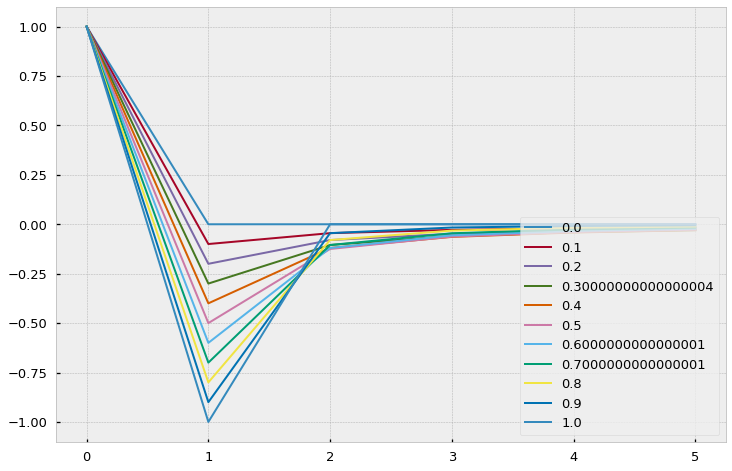

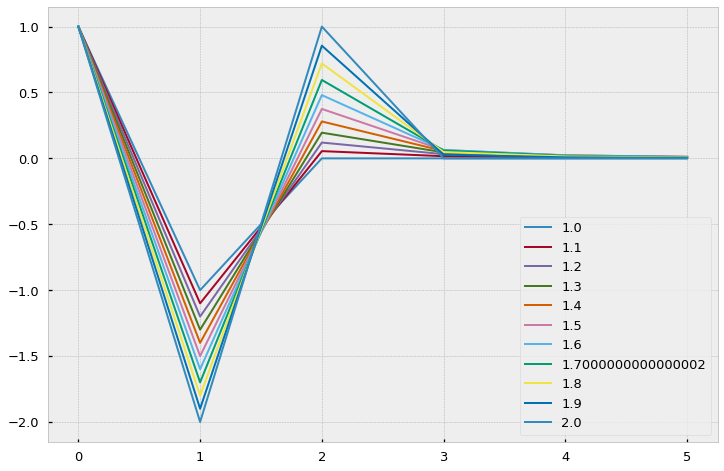

In [20]:
#range(np.array((6, 1)).shape[0])[::-1]
plotWeights(dRange=[0, 1], nPlots=11, size=6)
plotWeights(dRange=[1, 2], nPlots=11, size=6)

In [21]:
def fractDiff(series, d, thres=0.1):
    '''
    Increasing width window, with treatment of NaNs
    Note 1. for thres = 1, nothing is skipped
    Note 2. d can be any positive frational, not necesserly bounded in [0, 1]
    '''
    #1) Compute weights for the longest series
    w = getWeights(d, series.shape[0])
    #2) Determine initial calcs to be skipped based on weight-loss threshold
    w_ = np.cumsum(abs(w))
    w_ /= w_[-1]
    skip = w_[w_ > thres].shape[0]
    #3) Apply weights to values
    df = {}
    for name in series.columns:
        seriesF, df_ = series[[name]].fillna(method='ffill').dropna(), pd.Series()
        for iloc in range(skip, seriesF.shape[0]):
            loc = seriesF.index[iloc]
            if not np.isinf(series.loc[loc, name]): 
                continue #exclude Na
            df_[loc] = np.dot(W[-(iloc+1):, :].T, seriesF.loc[:loc])[0, 0]
            k*(d-k+1)
        df[name] = df_.copy(deep=True)
    df = pd.concat(df, axis=1)
    return df

In [22]:
def getWeights_FFD(d, thres):
    w, k = [1.], 1
    while True:
        w_ = -w[-1]/k*(d-k+1)
        if(abs(w_) < thres): 
            break
        w.append(w_) 
        k+=1
    return np.array(w[::-1]).reshape(-1,1)
#---------------------------------
def fracDiff_FFD(series, d, thres=1e-5):
    # Constant widht window (new solution)
    w = getWeights_FFD(d, thres)
    widht = len(w)-1
    df = {}
    for name in series.columns:
        seriesF = series[[name]].fillna(method='ffill').dropna()
        df_ = pd.Series()
        for iloc1 in range(widht, seriesF.shape[0]):
            loc0 = seriesF.index[iloc1 - widht]
            loc1 = seriesF.index[iloc1]
            #print(loc0, loc1, widht)
            if(not np.isfinite(series.loc[loc1, name])):
                continue # Exclude NaNs
            #print('>> ',np.dot(w.T, seriesF.loc[loc0:loc1])[0, 0])
            df_[loc1] = np.dot(w.T, seriesF.loc[loc0:loc1])[0, 0]
        df[name] = df_.copy(deep=True)
    df = pd.concat(df, axis=1)
    return df
#----------------------------
def plotWeights_FFD(dRange, nPlots, size):
    w = pd.DataFrame()
    for d in np.linspace(dRange[0], dRange[1], nPlots):
        w_ = getWeights_FFD(d, thres=0.01)
        w_ = pd.DataFrame(w_, index=range(w_.shape[0])[::-1], columns=[d])
        w = w.join(w_, how='outer')
    ax = w.plot(figsize=(12, 8))
    ax.legend(loc='lower right')
    plt.show()
    return

In [23]:
def plot_autocorr(bar_types,bar_returns, sharey=True):
    f,axes=plt.subplots(len(bar_types),figsize=(10,7), sharey=sharey)

    for i, (bar, typ) in enumerate(zip(bar_returns, bar_types)):
        sm.graphics.tsa.plot_acf(bar, lags=120, ax=axes[i],
                                 alpha=0.05, unbiased=True, fft=True,
                                 zero=False,
                                 title=f'{typ} AutoCorr')

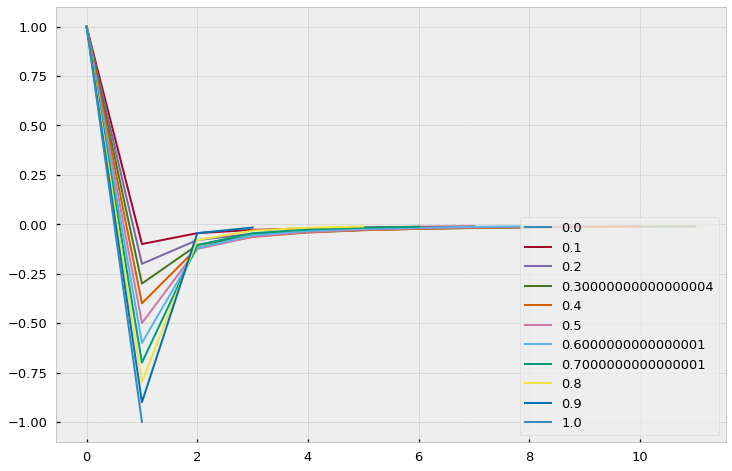

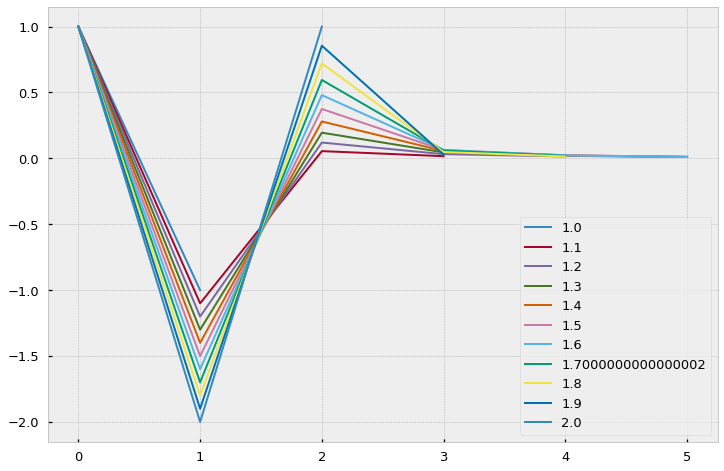

In [24]:
plotWeights_FFD(dRange=[0, 1], nPlots=11, size=6)
plotWeights_FFD(dRange=[1, 2], nPlots=11, size=6)

# Exercises

## Import Dataset

Note this dataset below has been resampled to `1s` and then `NaNs` removed. This was done to remove any duplicate indices not accounted for in a simple call to `pd.DataFrame.drop_duplicates()`. 

In [25]:
infp = PurePath(data_dir/'processed'/'IVE_dollarValue_resampled_1s.parquet')
#infp = PurePath(data_dir/'interim'/'IVE_tickbidask.parq')
df = pd.read_parquet(infp)
cprint(df)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                      price     bid     ask  size     v         dv
dates                                                             
2018-09-04 15:59:55  115.93  115.92  115.93   803   803   93091.79
2018-09-04 15:59:56  115.92  115.91  115.92   155   155   17967.60
2018-09-04 16:00:00  115.92  115.91  115.92  8570  8570  993434.40
2018-09-04 16:10:00  115.92  114.46  117.06     0     0       0.00
2018-09-04 18:30:00  115.92  115.35  116.57     0     0       0.00
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1010793 entries, 2009-09-28 09:30:00 to 2018-09-04 18:30:00
Data columns (total 6 columns):
price    1010793 non-null float64
bid      1010793 non-null float64
ask      1010793 non-null float64
size     1010793 non-null int64
v        1010793 no

In [26]:
df = df[~df.index.duplicated(keep='last')]
cprint(df)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                      price     bid     ask  size     v         dv
dates                                                             
2018-09-04 15:59:55  115.93  115.92  115.93   803   803   93091.79
2018-09-04 15:59:56  115.92  115.91  115.92   155   155   17967.60
2018-09-04 16:00:00  115.92  115.91  115.92  8570  8570  993434.40
2018-09-04 16:10:00  115.92  114.46  117.06     0     0       0.00
2018-09-04 18:30:00  115.92  115.35  116.57     0     0       0.00
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1010793 entries, 2009-09-28 09:30:00 to 2018-09-04 18:30:00
Data columns (total 6 columns):
price    1010793 non-null float64
bid      1010793 non-null float64
ask      1010793 non-null float64
size     1010793 non-null int64
v        1010793 no

In [27]:
dbars = dollar_bar_df(df, 'dv', 1_000_000).drop_duplicates().dropna()
cprint(dbars)

100%|██████████| 1010793/1010793 [00:00<00:00, 2376265.18it/s]

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                        price     bid     ask  size     v           dv
dates                                                                 
2018-09-04 15:21:31  115.8437  115.84  115.85   888   888  102869.2056
2018-09-04 15:30:57  115.8200  115.82  115.83   299   299   34630.1800
2018-09-04 15:43:51  115.7721  115.77  115.78   370   370   42835.6770
2018-09-04 15:55:27  115.7500  115.74  115.75  1300  1300  150475.0000
2018-09-04 15:59:56  115.9200  115.91  115.92   155   155   17967.6000
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34419 entries, 2009-09-28 09:53:49 to 2018-09-04 15:59:56
Data columns (total 6 columns):
price    34419 non-null float64
bid      34419 non-null float64
ask      34419 non-null float64
size     34419 non-null int64
v

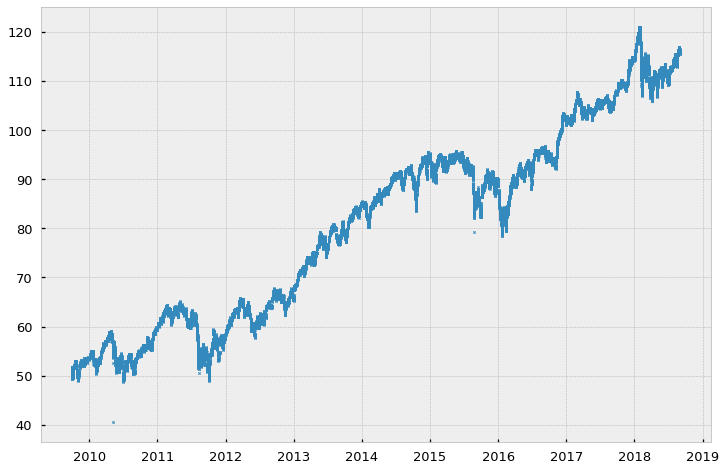

In [28]:
plt.figure(figsize=(12, 8))
plt.plot(dbars.price, ls='', marker='X', markersize=3)
plt.show()

<Figure size 864x576 with 0 Axes>

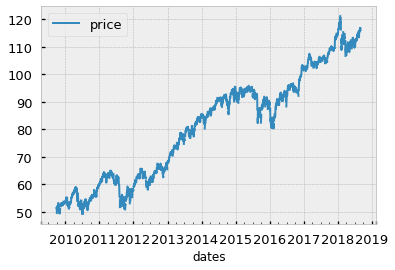

In [29]:
df0 = dbars[['price']].resample('1D').last()
plt.figure(figsize=(12, 8))
df0.plot()
plt.show()

In [30]:
cprint(df0)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
             price
dates             
2018-08-31  116.05
2018-09-01     NaN
2018-09-02     NaN
2018-09-03     NaN
2018-09-04  115.92
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3264 entries, 2009-09-28 to 2018-09-04
Freq: D
Data columns (total 1 columns):
price    2250 non-null float64
dtypes: float64(1)
memory usage: 51.0 KB
None
-------------------------------------------------------------------------------



In [31]:
name = 'price'

#w = getWeights_FFD(d=0.8, thres=0.01)
#f = fracDiff_FFD(series=df0, d=0.3, thres=0.001)
#f
correlations = []
for d in np.linspace(0, 1, 21):
    #print(d)
    df1 = np.log(df0[[name]])
    #print(df1.head())
    df2 = fracDiff_FFD(df1, d, thres=.001)
    corr = np.corrcoef(df1.loc[df2.index, name], df2[name])[0,1]
    correlations.append(corr)
    print(d, corr)

0.0 0.9999999999999998
0.05 0.9999049462839374
0.1 0.9993381030735812
0.15000000000000002 0.9979115510538942
0.2 0.9953496637074817
0.25 0.9911216157048945
0.30000000000000004 0.9847912710080553
0.35000000000000003 0.9751526068139804
0.4 0.96140917516702
0.45 0.9420943767671593
0.5 0.9140721786653777
0.55 0.8759533817345987
0.6000000000000001 0.8287101272783628
0.65 0.7657497694350778
0.7000000000000001 0.6926999796735046
0.75 0.6130227109003276
0.8 0.5320004166604992
0.8500000000000001 0.43061022406539873
0.9 0.3246945395912349
0.9500000000000001 0.2240689031743539
1.0 0.016114162224769583


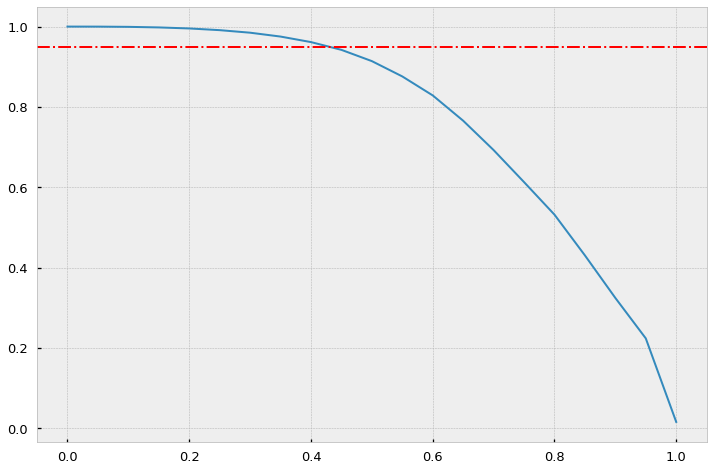

In [32]:
correlations = np.array(correlations).reshape((-1, 1))
xValues = np.linspace(0, 1, 21)
plt.figure(figsize=(12,8))
plt.plot(xValues, correlations)
plt.axhline(y=0.95, color='red', ls='-.')
plt.show()

In [33]:
best_d = 0.45
df2 = fracDiff_FFD(df1, d, thres=.001)

In [34]:
print('df1.shape', df1.shape)
print('df2.shape', df2.shape)

df1.shape (3264, 1)
df2.shape (2249, 1)


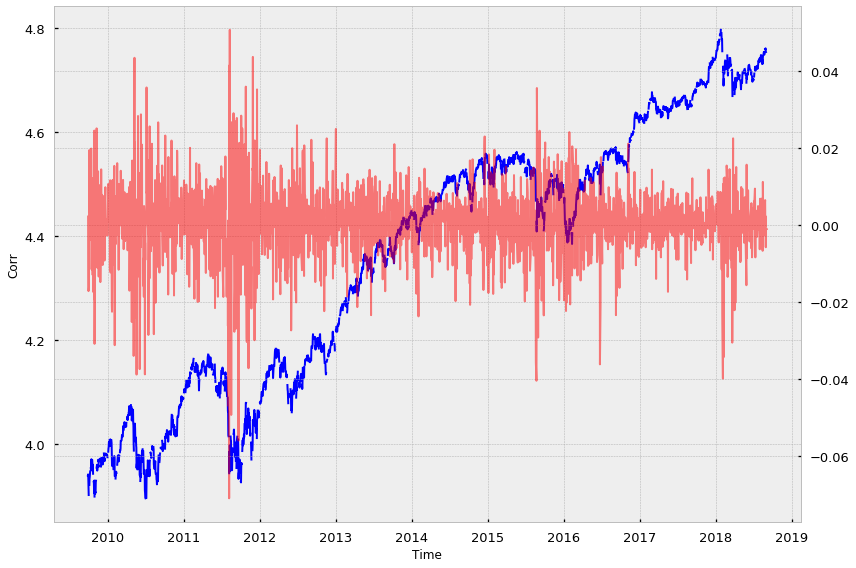

In [35]:
fig, ax1 = plt.subplots(figsize=(12, 8))
ax1.plot(df1.price, 'b-')
ax1.set_xlabel('Time')
ax1.set_ylabel('Price')

ax2 = ax1.twinx()
ax2.plot(df2.price, color='red', alpha=0.5)
#ax1.set_xlabel('Time')
ax1.set_ylabel('Corr')

#ax2.set_ylabel('sin', color='r')
#ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()

#plt.figure(figsize=(12, 8))
#plt.plot(df1.price)
#plt.plot(df2.price)
#plt.show()

## Exercises [5.1]
Generate a time series from an IID Gaussian random process. This is a memory-less, stationary series
### [5.1.a] Compute the ADF statistic on this series. What is P-Value?
### [5.1.b] Compute the cumulative sum of the observations. This is a non-stationary series without memory
- What is the order of integration of this cumulative series
- Compute the ADF statistic on this series, what is the P-Value?

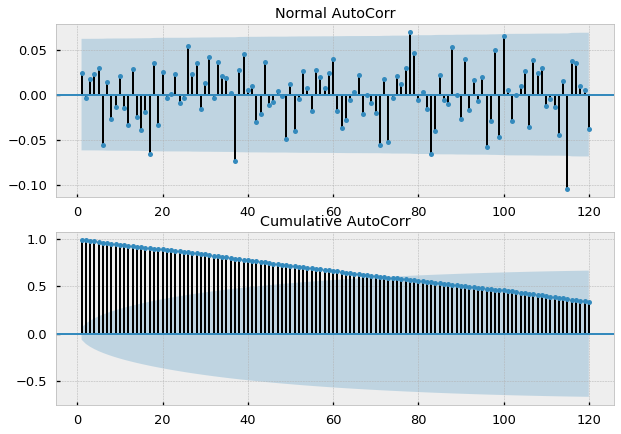

In [36]:
np.random.seed(123)
randn = pd.Series(np.random.randn(1000))
cum_randn = randn.cumsum()
typ = 'Normal'
#randn = randn.autocorr()
#print(randn)
plot_autocorr(bar_types=['Normal', 'Cumulative'], bar_returns=[randn, cum_randn], sharey=False)

In [37]:
from scipy.stats import ttest_1samp
print(ttest_1samp(randn, 0))
print(ttest_1samp(cum_randn, 0))

Ttest_1sampResult(statistic=-1.2495180739734473, pvalue=0.21176831113941572)
Ttest_1sampResult(statistic=-29.977707524494463, pvalue=2.379088613119234e-141)


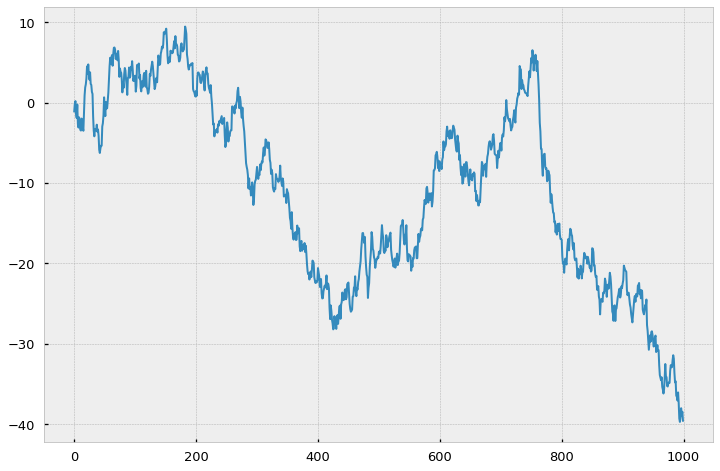

In [38]:
plt.figure(figsize=(12, 8))
plt.plot(cum_randn)
plt.show()

### [5.1.c] Differentiate the series twice. What is the P-Value of this over-differentiated

In [39]:
twice_randn = np.diff(randn)

Ttest_1sampResult(statistic=-0.0005836506862682365, pvalue=0.9995344307951317)


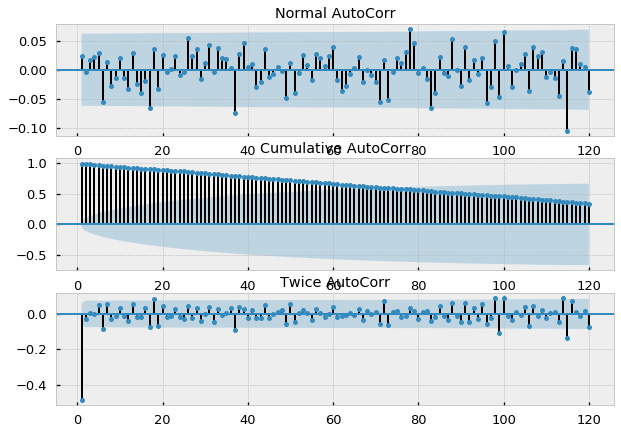

In [40]:
plot_autocorr(bar_types=['Normal', 'Cumulative', 'Twice'], bar_returns=[randn, cum_randn, twice_randn], sharey=False)

print(ttest_1samp(twice_randn, 0))

## Exercises [5.2]
Generate a time series that follows a sinusoidal funciton. This is a stationary series with memory

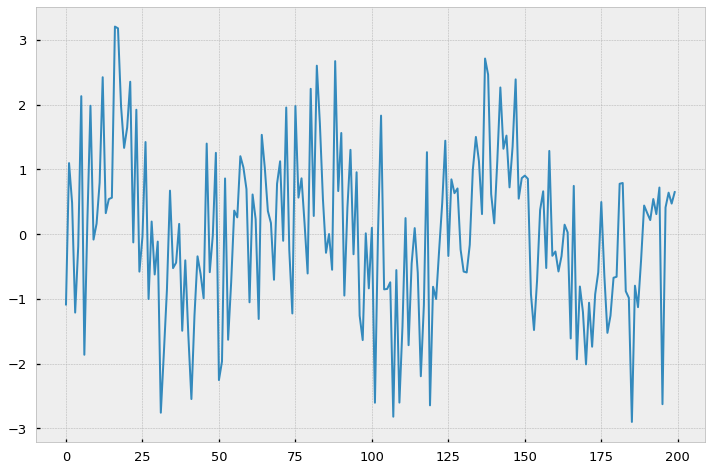

In [41]:
np.random.seed(123)
sinusoidal = np.sin(np.arange(0, 20, 0.1)) 
noise = np.random.randn(sinusoidal.shape[0])
sinusoidal = sinusoidal +noise
plt.figure(figsize=(12, 8))
plt.plot(sinusoidal)
plt.show()

### [5.2.a] Compute the ADF statistic on this series. What is the P-Value?

Ttest_1sampResult(statistic=0.3504519524420893, pvalue=0.726370217278564)


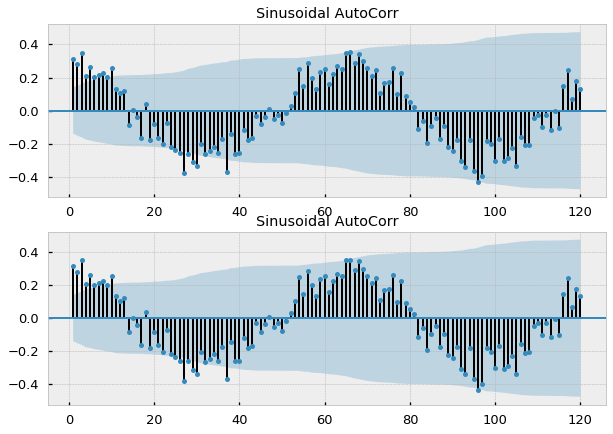

In [42]:
plot_autocorr(bar_types=['Sinusoidal', 'Sinusoidal'], bar_returns=[sinusoidal, sinusoidal])

print(ttest_1samp(sinusoidal, 0))

### [5.2.b] 
- Shift every observation by the same positivie value. 
- Compute the cumulative sum of the observations.
- This is a non-stationary series with memory 

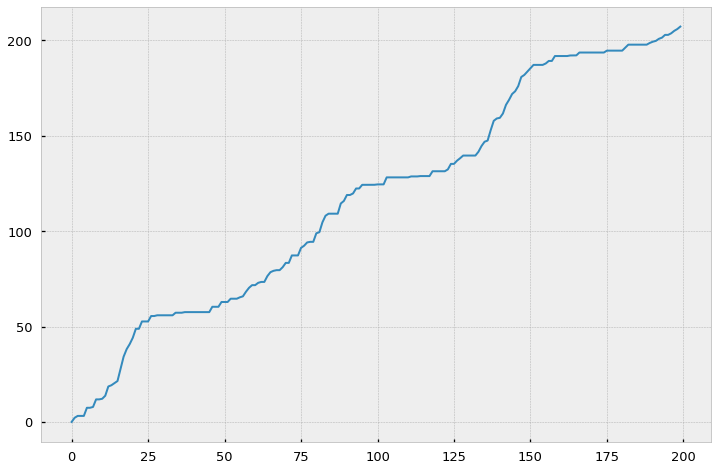

In [43]:
shifted_sinusoidal = sinusoidal+np.abs(sinusoidal)
plt.figure(figsize=(12, 8))
plt.plot(np.cumsum(shifted_sinusoidal))
plt.show()

#### [5.2.b.i]  Compute the ADF statistic on this series. What is the P-Value?

Ttest_1sampResult(statistic=9.882504027456871, pvalue=5.426018111984659e-19)


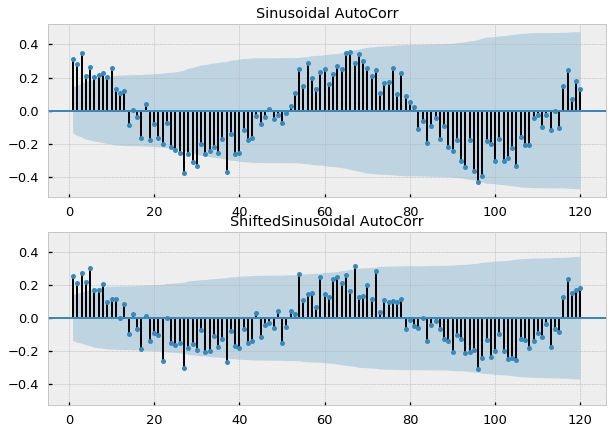

In [44]:
plot_autocorr(bar_types=['Sinusoidal', 'ShiftedSinusoidal'], bar_returns=[sinusoidal, shifted_sinusoidal])

print(ttest_1samp(shifted_sinusoidal, 0))